In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.14
3.11.6
1.11.3


In [60]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6

# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes =  []
for i in range(n_node):
    if [xs[i],ys[i]]!= [0,0] and [xs[i],ys[i]] != [0,y_span] and [xs[i],ys[i]] != [x_span,y_span] and [xs[i],ys[i]] != [x_span,0]:
        design_nodes.append(i)
    else:
        non_design_nodes.append(i)
        if [xs[i],ys[i]]== [x_span/2,y_span/2]:
            loading_nodes.append(i)
            
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

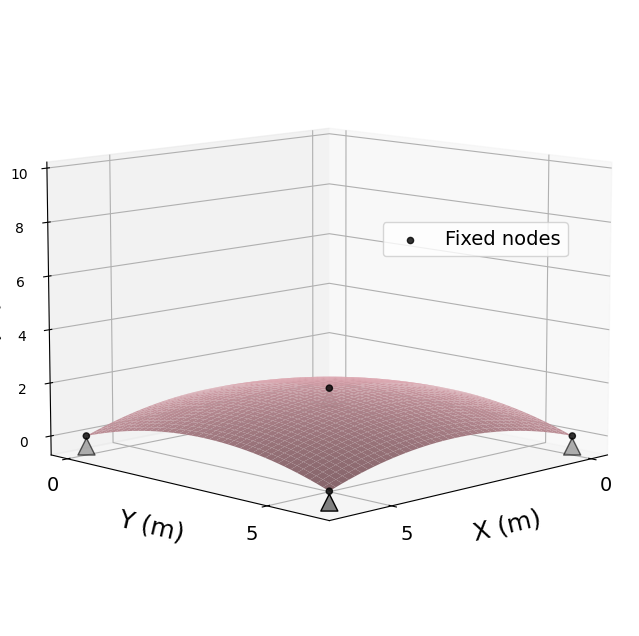

In [61]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

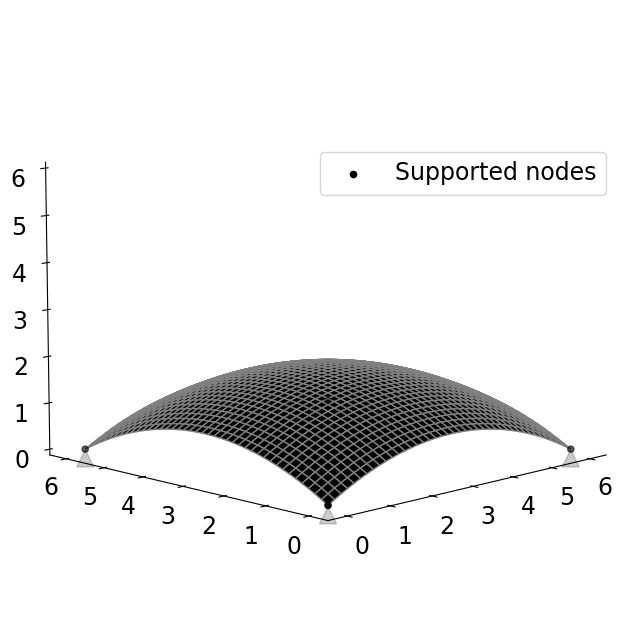

In [62]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

In [63]:
non_design_nodes

array([   0,   40, 1640, 1680])

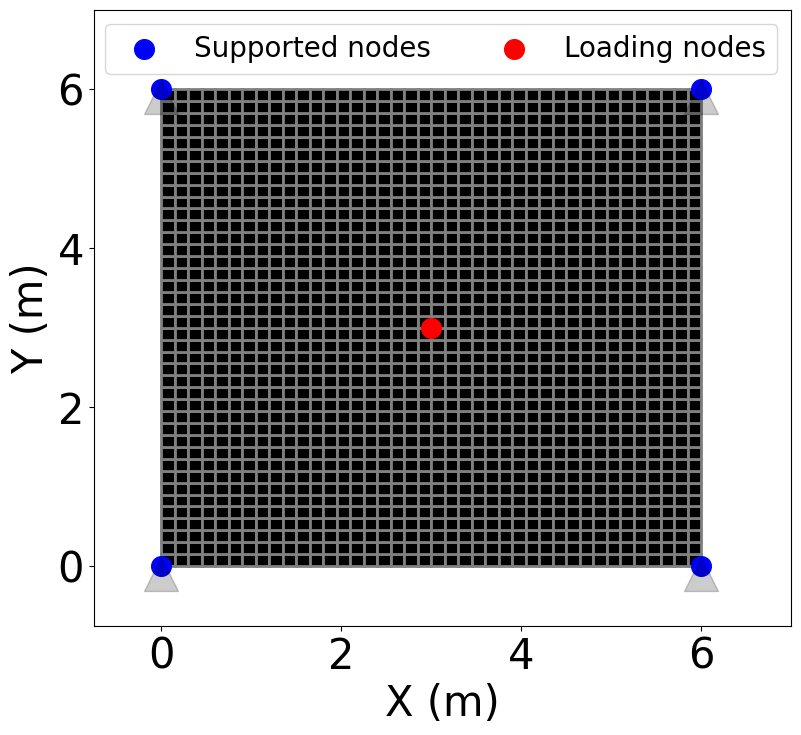

In [64]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[int(n_node/2)],ys[int(n_node/2)],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [65]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [66]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [67]:
B_ij.shape

(1681, 1681)

In [68]:
n_node/2

840.5

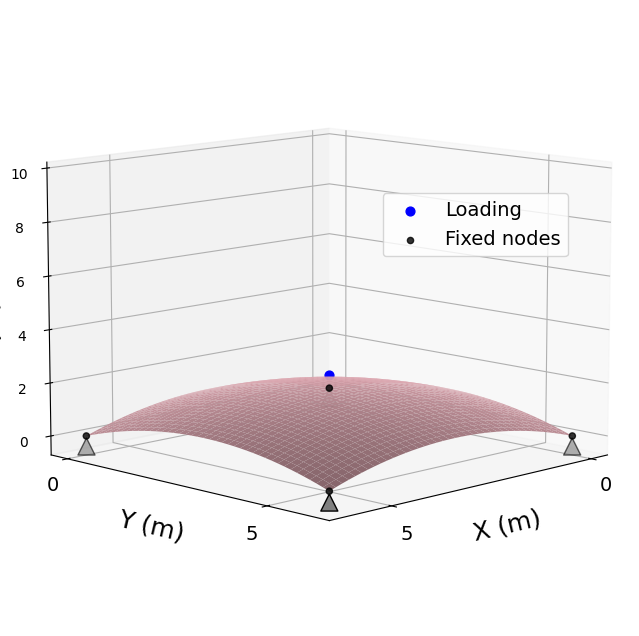

In [69]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[int(n_node/2)],ys[int(n_node/2)],zs[int(n_node/2)]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [70]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [71]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.5)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [72]:
B_ij_shell.shape

(1600, 1600)

In [73]:
#W(A): total volume
def coeff_E(mu,p=2):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    plt.title('{}-th iteration'.format(i),fontsize=15)
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

In [74]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i== int(n_node/2):
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [75]:
model.solve()

In [76]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [42]:
sso_model.parameter_values.shape

(1600,)

In [43]:
sso_model.eleparameters_values.shape

(1600,)

In [77]:
C_hist = []
mu_sum_list =[]
def objective_filter(x,sso_model=sso_model):
    '''
    Design parameters:
    node params: normalized control point (pre filtered)
    ele params: pre-filtered mu
    '''
    ele_params = x
    p = 2 + len(C_hist)*0.02

    #pre-filtered mu
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p) #Penalized Young's modulus
    sso_model.update_eleparameter(E_step) # Update the model
    
    #JAX-SSO
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    C_hist.append(C)
    print("{}th iteration, C = {} ".format(len(C_hist),C))
    mu_sum_list.append(np.sum(ele_params))
    
    
    sens_ele =sens[sso_model.nodeparameters_values.shape[0]:]
    sens_topo = sens_ele@jacfwd(coeff_E)(B_ij_shell@x[sso_model.nodeparameters_values.shape[0]:],p)
    sens_topo_final = sens_topo@B_ij_shell
    
    
    
    if len(C_hist)%5==0:
        i = len(C_hist)
        print(jnp.sum(ele_params))
        plt_plan(filtered_mu,i)
    return float(C), sens_topo_final

In [78]:
x_ini = 0.1*np.ones(sso_model.eleparameters_values.shape[0])

In [51]:
objective_filter(x_ini)

1th iteration, C = 4.977407932638695 


(4.977407932638695,
 Array([-0.62568808, -0.60349564, -0.45976687, ..., -0.45976687,
        -0.60349564, -0.62568808], dtype=float64))

# Implementing MMA

In [79]:
import nlopt

In [80]:
#Nlopt objective and constraints
def f(x,grad):
    res_1,res_2 = objective_filter(x)
    if grad.size>0:
        grad[:] = res_2

    return res_1

#Constraints on volume minimization
def vol(x):
    '''
    Return the volume constraints
    '''
    mu = x[sso_model.nodeparameters_values.shape[0]:] #the density
    return jnp.sum(mu)-0.5*sso_model.eleparameters_values.shape[0]
def fc(x,grad):
    res_1,res_2 = value_and_grad(vol)(x) 
    if grad.size>0:
        grad[:] = res_2

    return float(res_1)

1th iteration, C = 8.763414913508976 
2th iteration, C = 2.899510742489802 
3th iteration, C = 2.73530580172912 
4th iteration, C = 1.6527505456713463 
5th iteration, C = 0.4920401238373084 
394.0194384474707


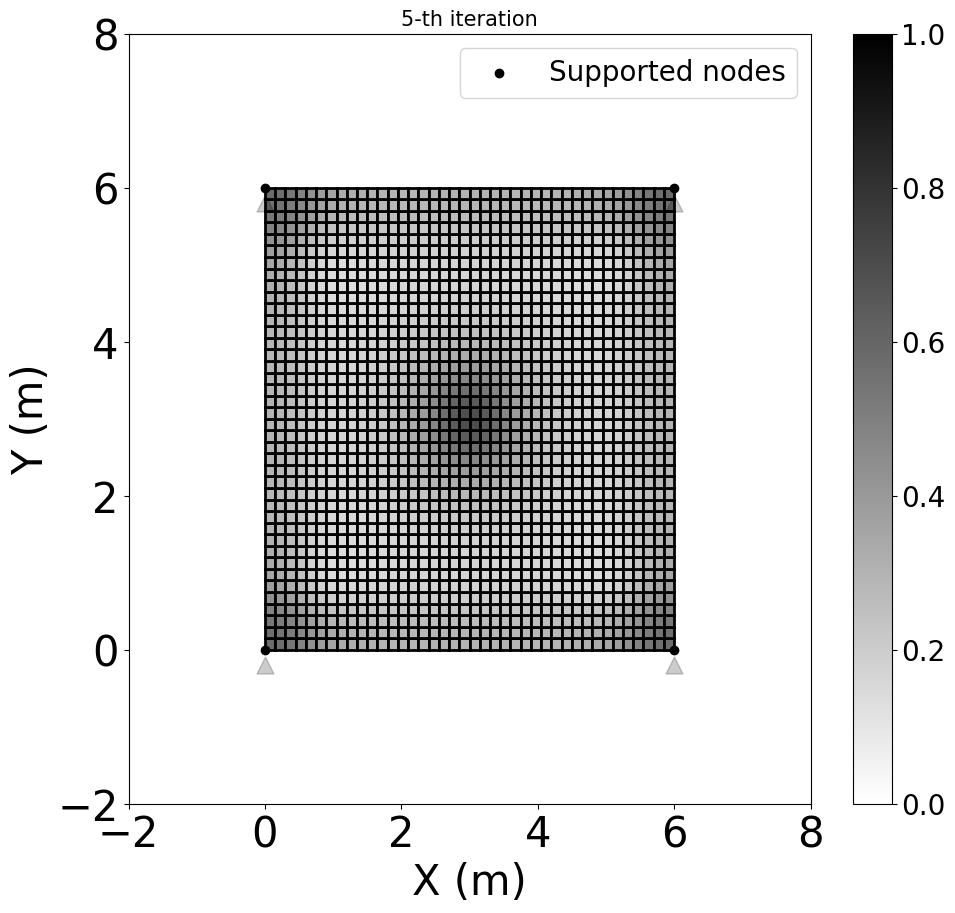

6th iteration, C = 0.4109287240080048 
7th iteration, C = 0.18913449323296244 
8th iteration, C = 0.13533272280095182 
9th iteration, C = 0.12753765715095858 
10th iteration, C = 0.12582204958782905 
795.8859147601581


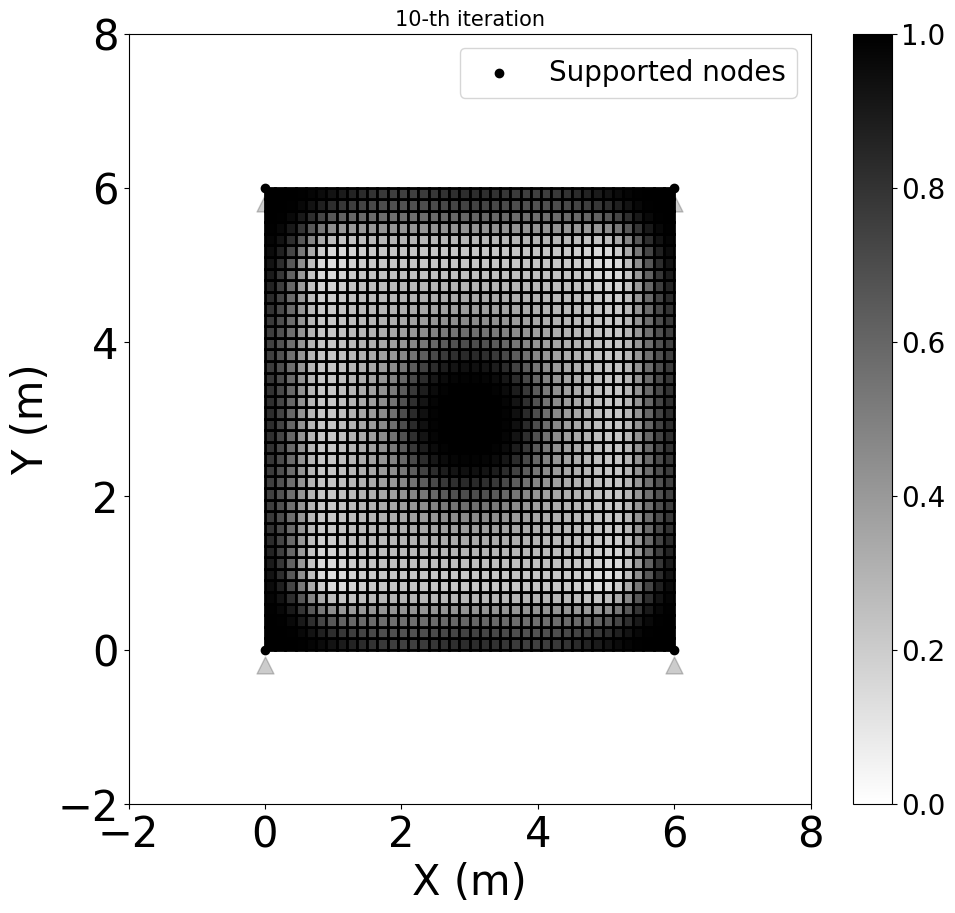

11th iteration, C = 0.12493585117189566 
12th iteration, C = 0.1249574882297728 
13th iteration, C = 0.12582767055843386 
14th iteration, C = 0.126577088815326 
15th iteration, C = 0.12737700158500403 
799.1852535338326


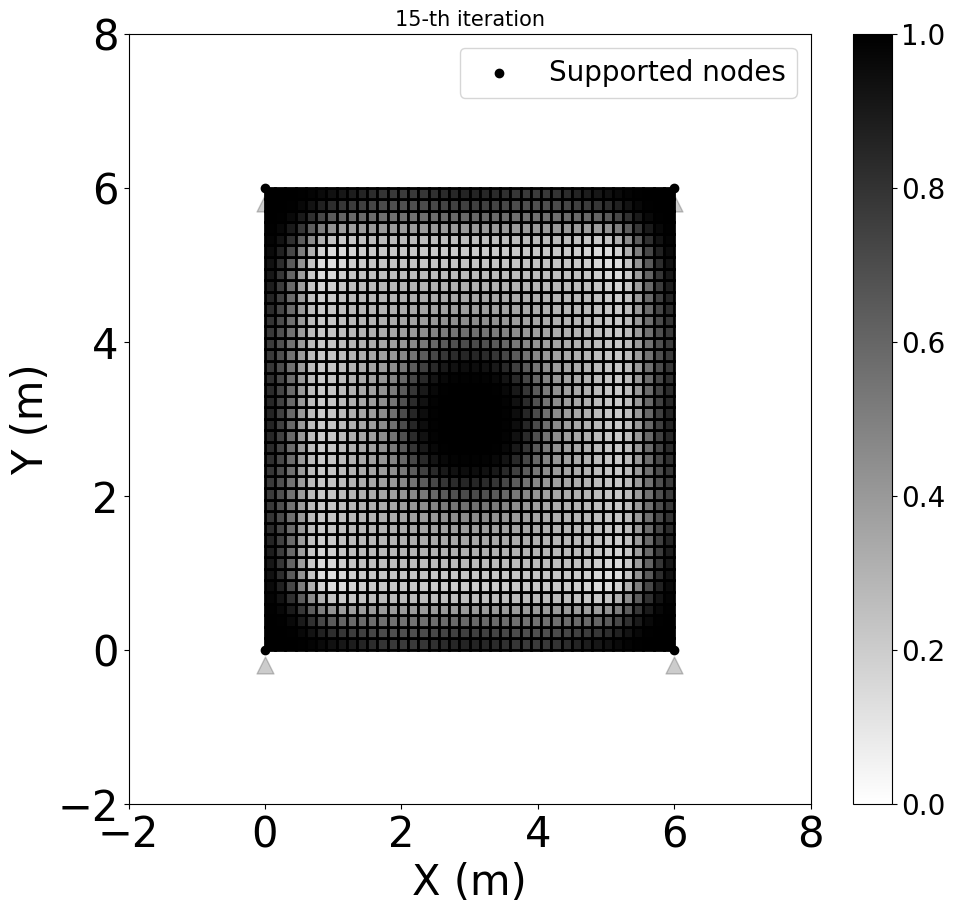

16th iteration, C = 0.1281122217004408 
17th iteration, C = 0.12879219044440232 
18th iteration, C = 0.1294777195119364 
19th iteration, C = 0.13017534351085028 
20th iteration, C = 0.13088603257534595 
798.719121031218


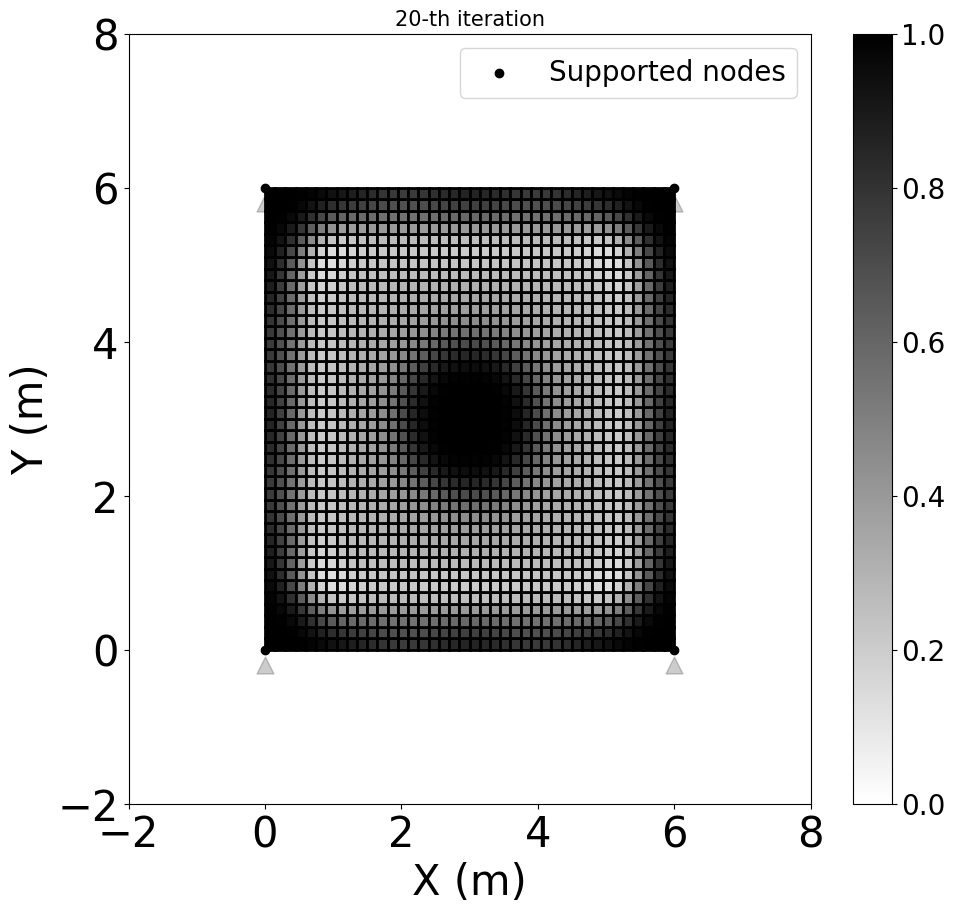

21th iteration, C = 0.13161019511272998 
22th iteration, C = 0.13234818877348475 
23th iteration, C = 0.13310037412216755 
24th iteration, C = 0.13386712204093584 
25th iteration, C = 0.13464881176989865 
798.7191163662413


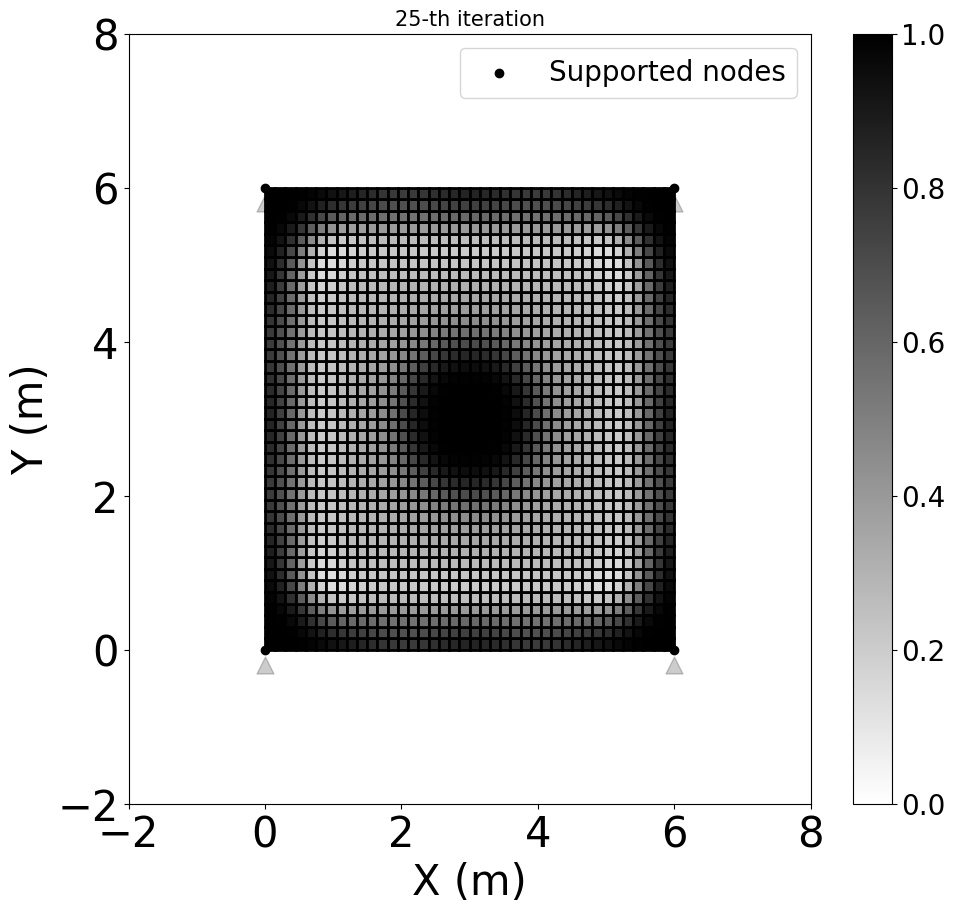

26th iteration, C = 0.1354458319540283 
27th iteration, C = 0.1362585822563082 
28th iteration, C = 0.13708747231682025 
29th iteration, C = 0.137932922653182 
30th iteration, C = 0.1387953638108845 
798.7191163661947


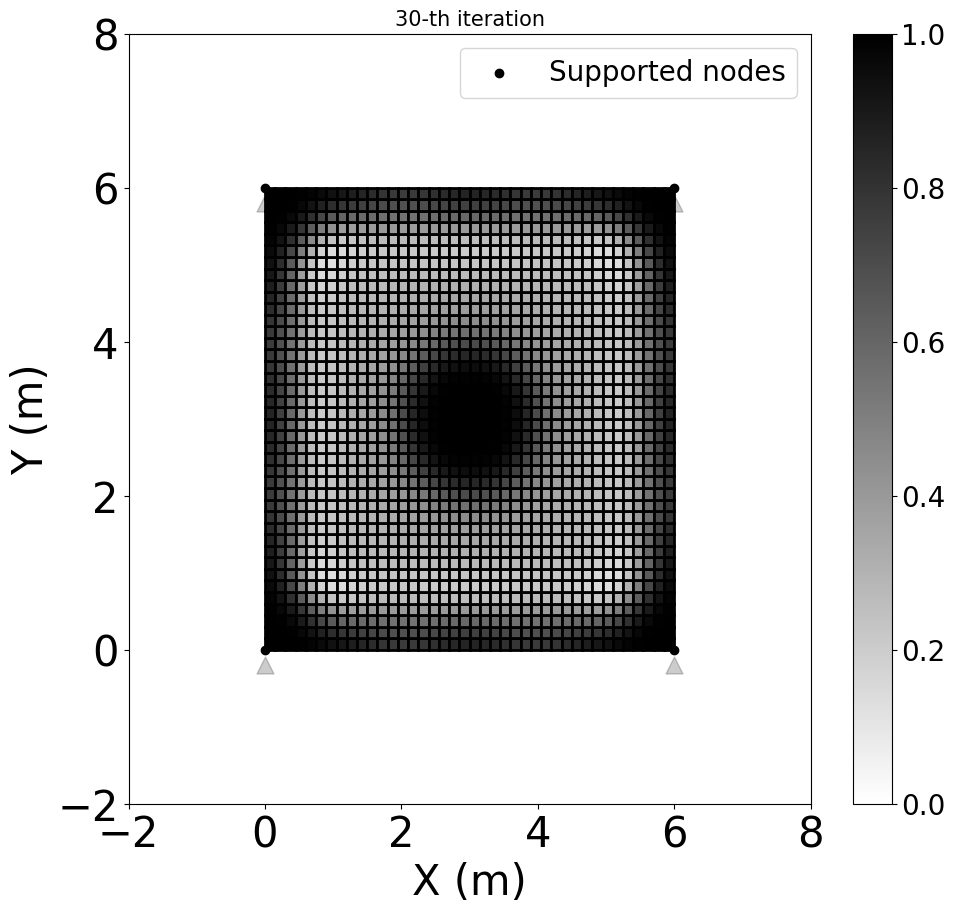

31th iteration, C = 0.13967523956409994 
32th iteration, C = 0.14057300289707558 
33th iteration, C = 0.14148911847663337 
34th iteration, C = 0.14242406577048042 
35th iteration, C = 0.1433783348322676 
798.7191163661947


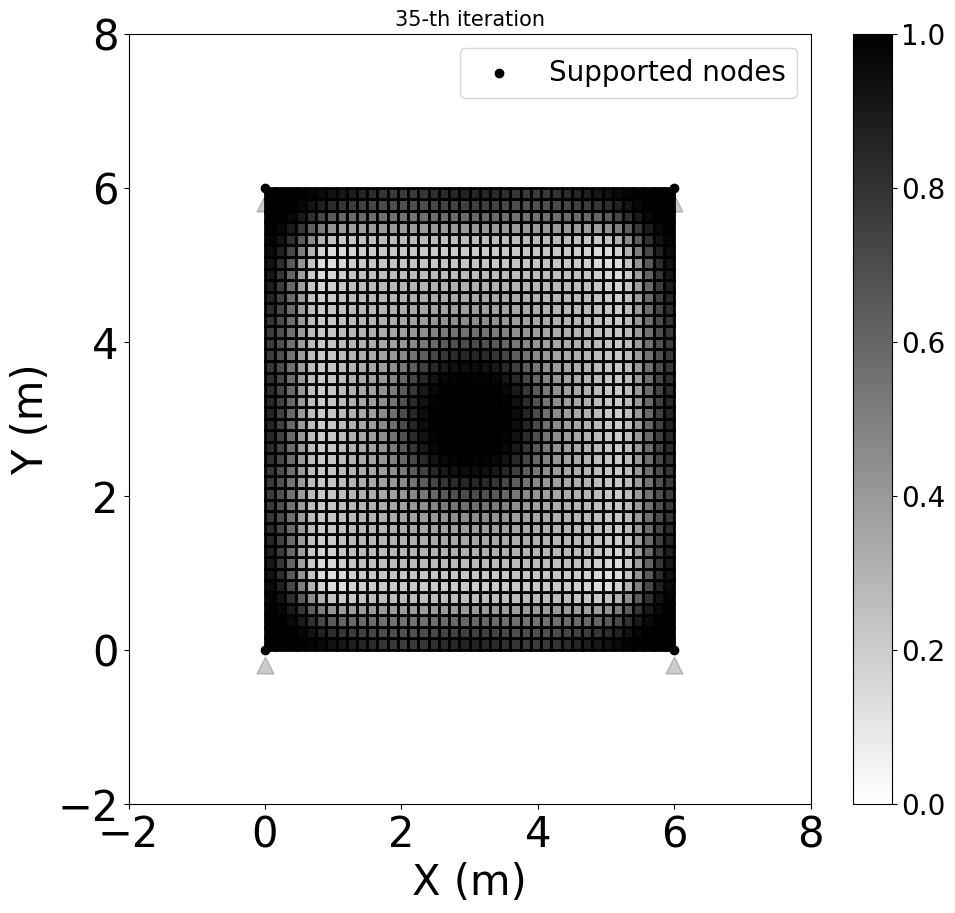

36th iteration, C = 0.14435242787530758 
37th iteration, C = 0.1453468615210194 
38th iteration, C = 0.14636216553428544 
39th iteration, C = 0.14739888238888188 
40th iteration, C = 0.14845757057494666 
798.7191163661947


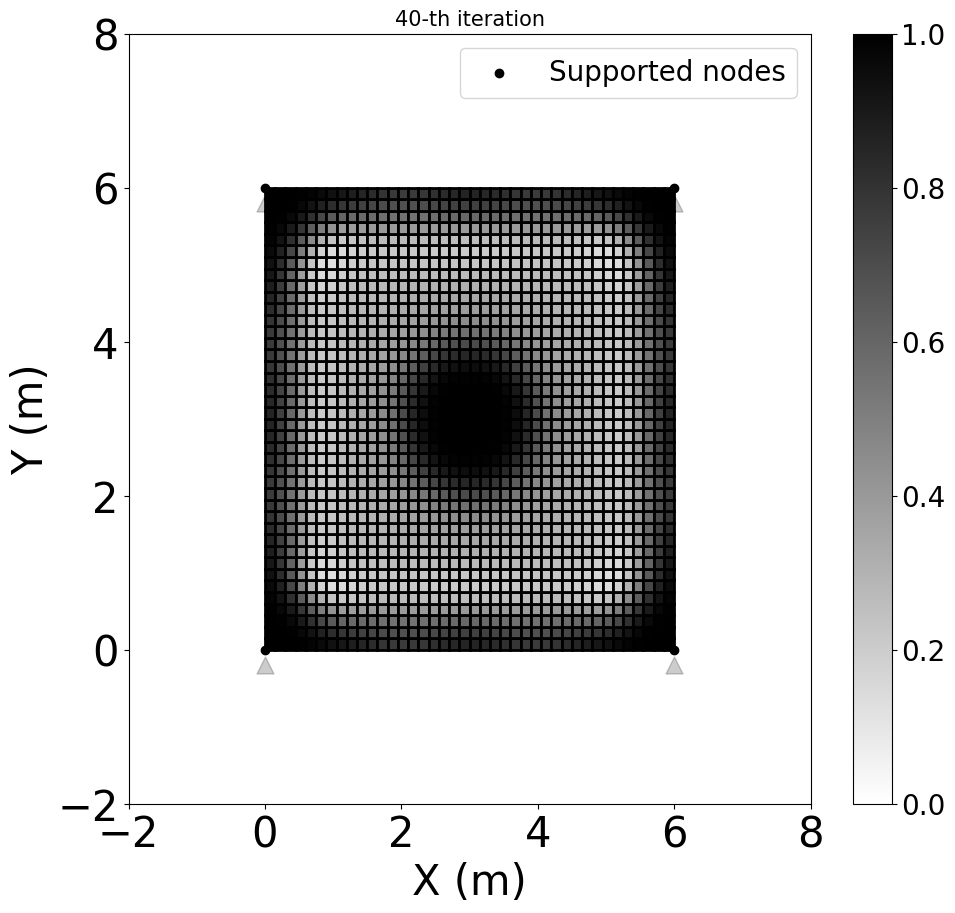

41th iteration, C = 0.14953880168639166 
42th iteration, C = 0.15064316262468377 
43th iteration, C = 0.15177125580024392 
44th iteration, C = 0.1529236994265278 
45th iteration, C = 0.15410112675572177 
798.7191163661947


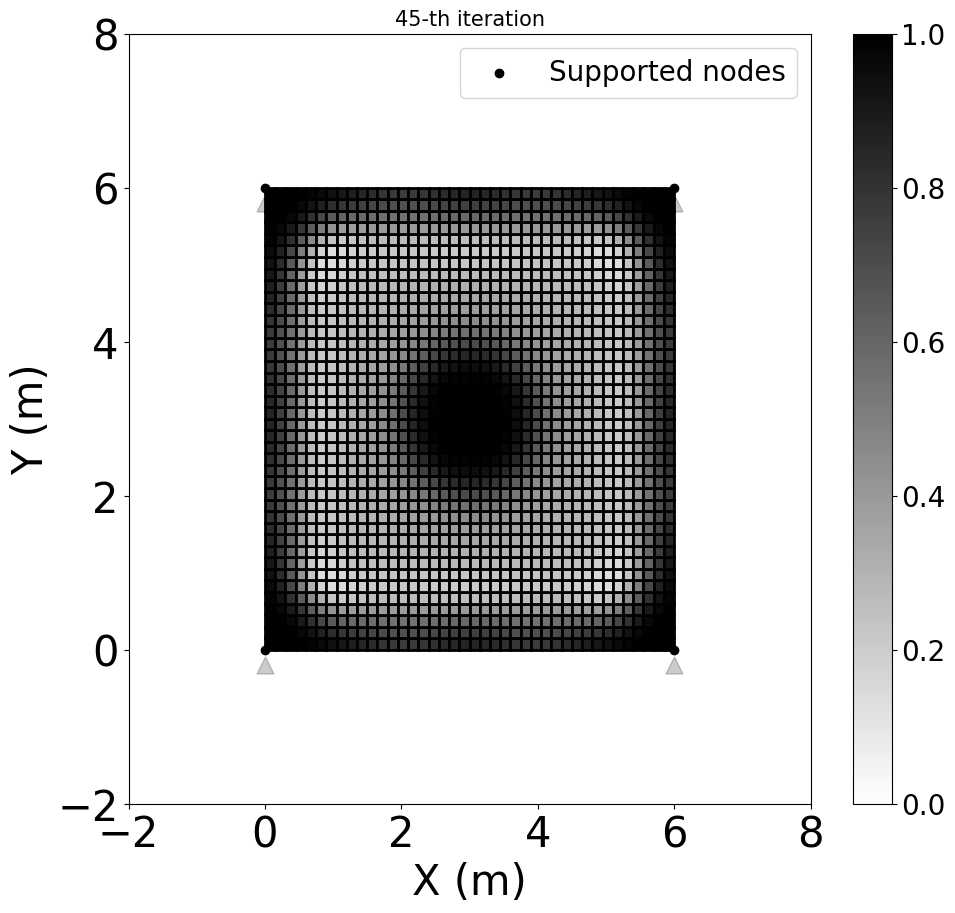

46th iteration, C = 0.15530418951932523 
47th iteration, C = 0.1565335543025876 
48th iteration, C = 0.15778990687930852 
49th iteration, C = 0.1590739503500906 
50th iteration, C = 0.16038640533525553 
798.7191163661947


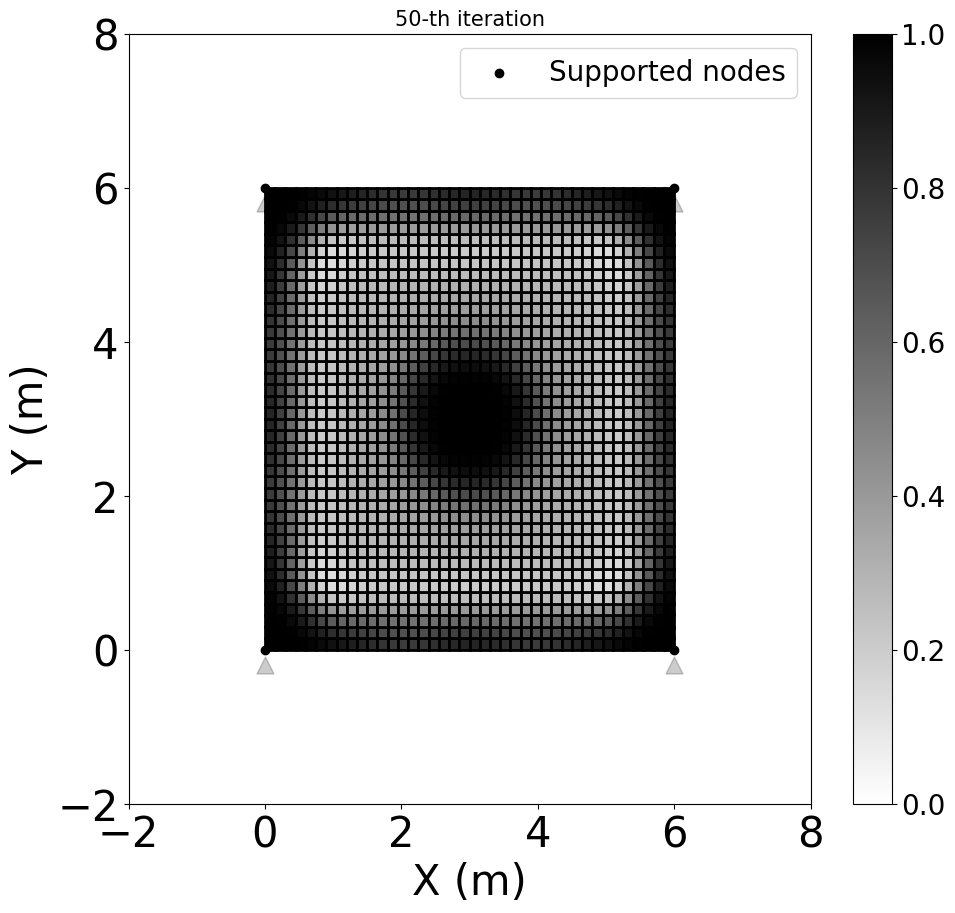

51th iteration, C = 0.1617280127970662 
52th iteration, C = 0.16309953242500377 
53th iteration, C = 0.164501742469294 
54th iteration, C = 0.16593544320263331 
55th iteration, C = 0.16740145583098917 
798.7191163661947


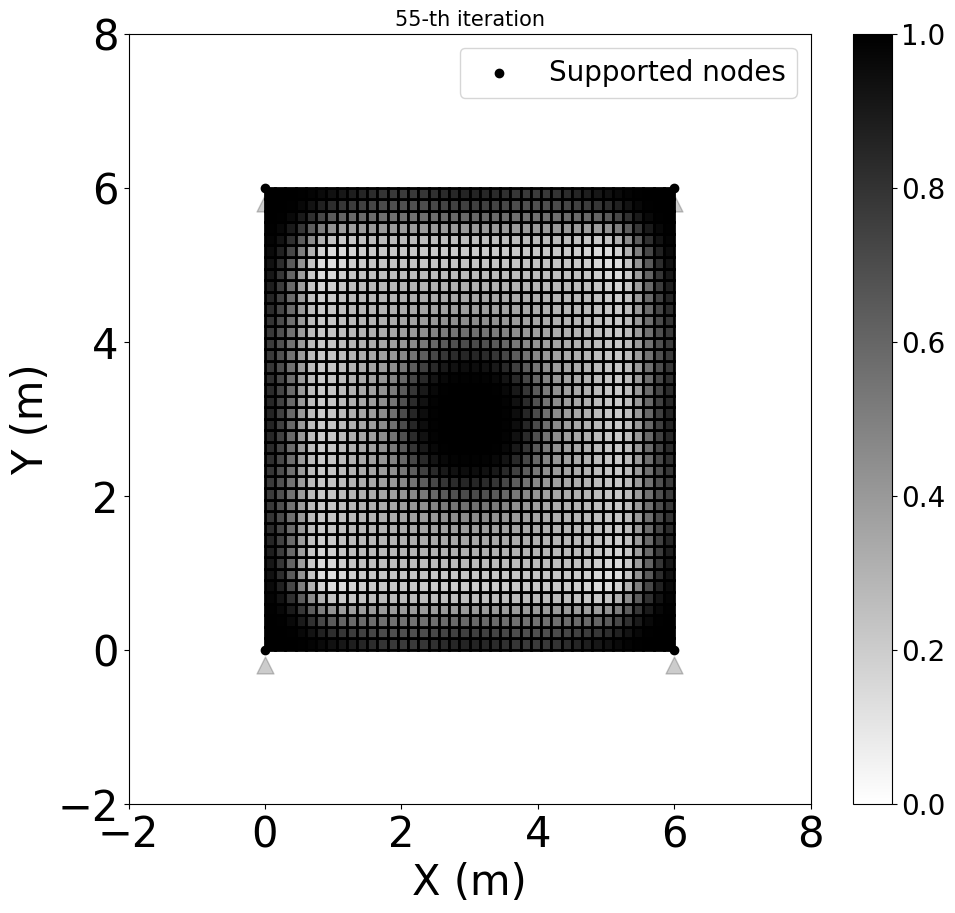

56th iteration, C = 0.16890062229535235 
57th iteration, C = 0.17043380652272264 
58th iteration, C = 0.17200189624698334 
59th iteration, C = 0.17360580045756369 
60th iteration, C = 0.17524645364203292 
798.7191163661947


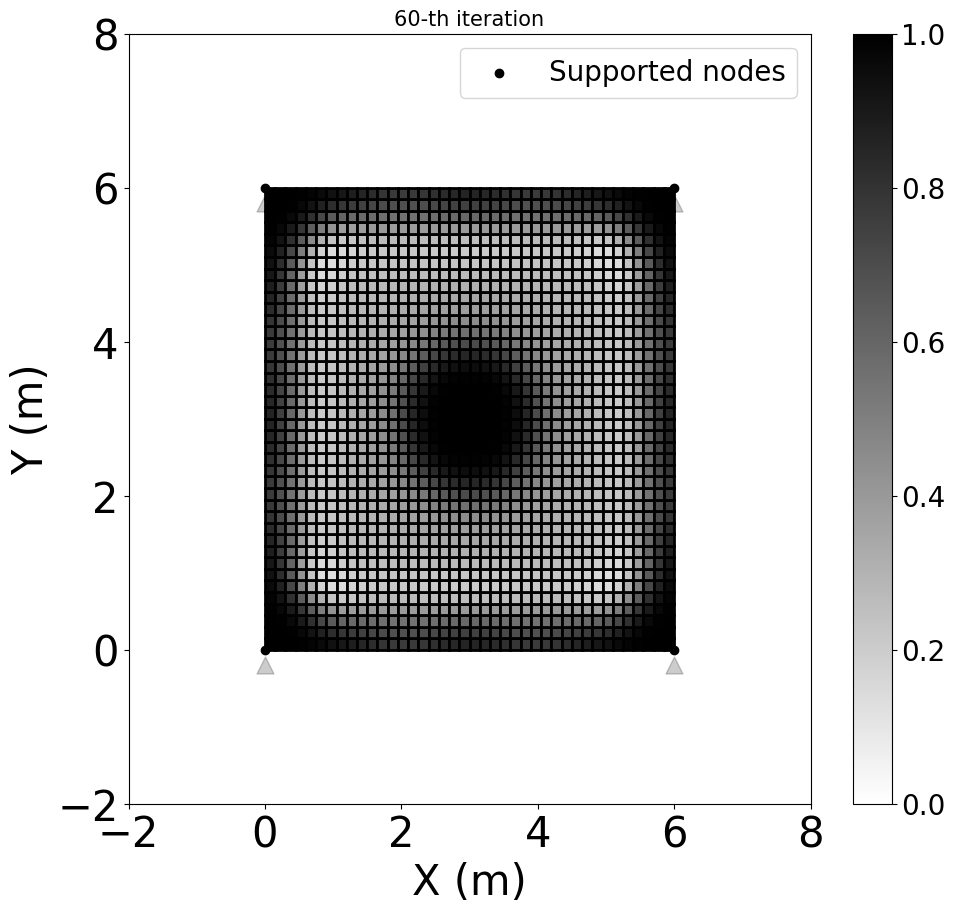

61th iteration, C = 0.176924813933504 
62th iteration, C = 0.17864186434182863 
63th iteration, C = 0.18039861472645177 
64th iteration, C = 0.1821961008950828 
65th iteration, C = 0.1840353850240579 
798.7191163661947


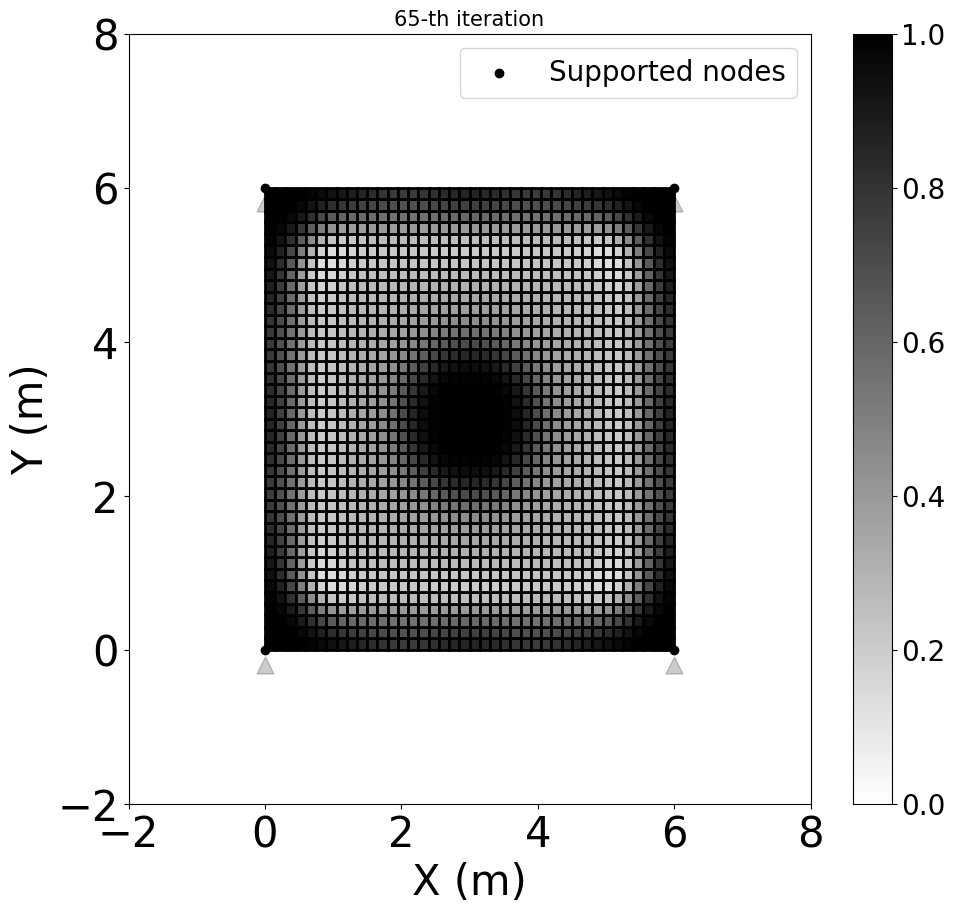

66th iteration, C = 0.18591755811896565 
67th iteration, C = 0.1878437385349298 
68th iteration, C = 0.18981507606123485 
69th iteration, C = 0.19183274887104915 
70th iteration, C = 0.19389796625790406 
798.7191163661947


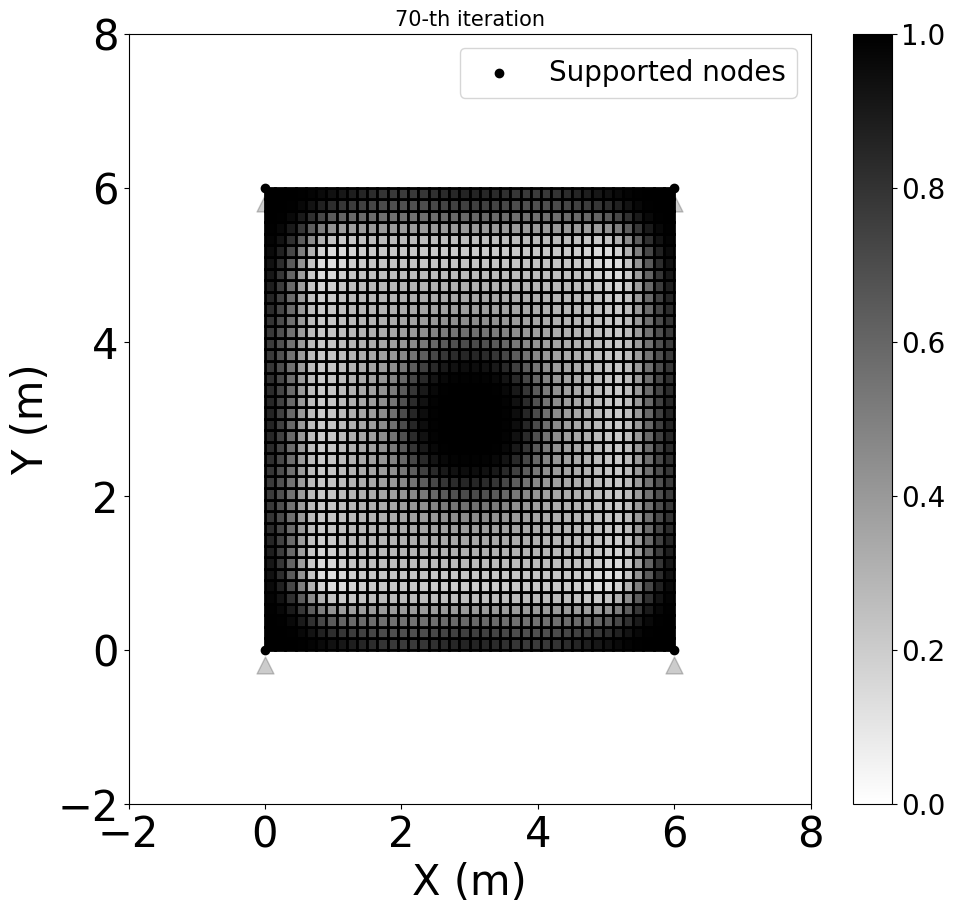

71th iteration, C = 0.196011969932362 
72th iteration, C = 0.19817603305027193 
73th iteration, C = 0.200391464004535 
74th iteration, C = 0.20265960358237592 
75th iteration, C = 0.20498182881678903 
798.7191163661947


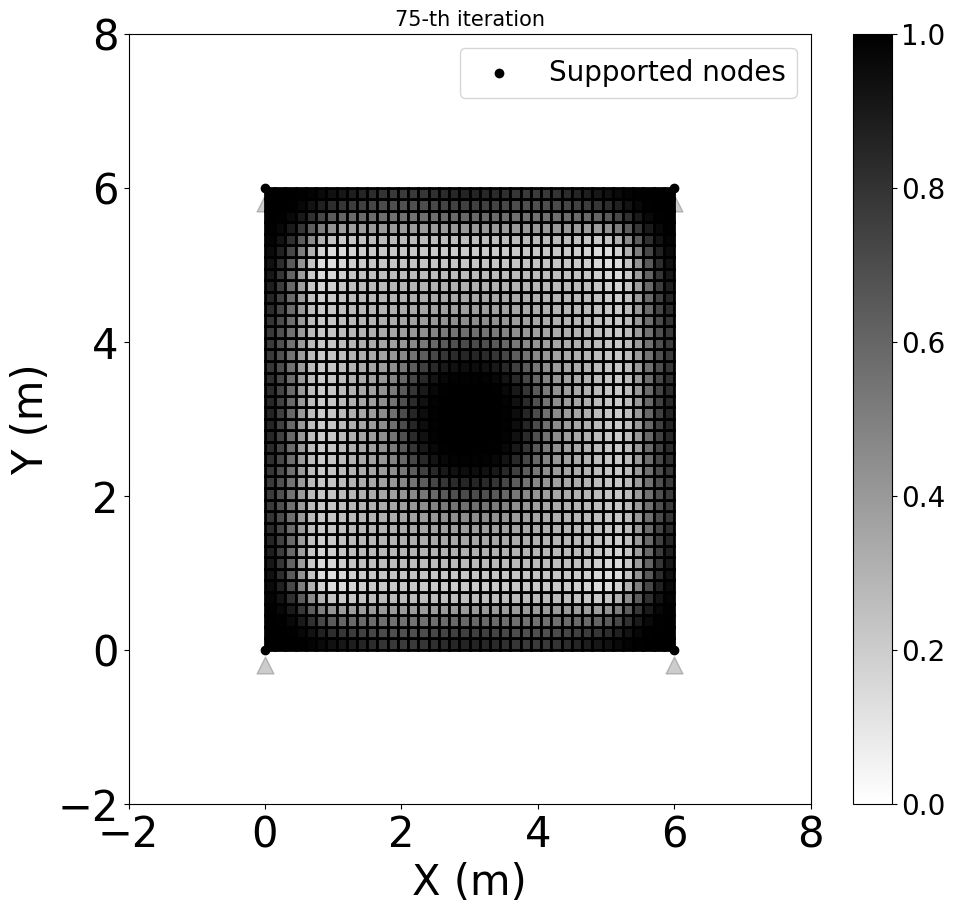

76th iteration, C = 0.2073595528594113 
77th iteration, C = 0.2097942250795105 
78th iteration, C = 0.21228733416054033 
79th iteration, C = 0.21484040686463965 
80th iteration, C = 0.21745501077713195 
798.7191163661947


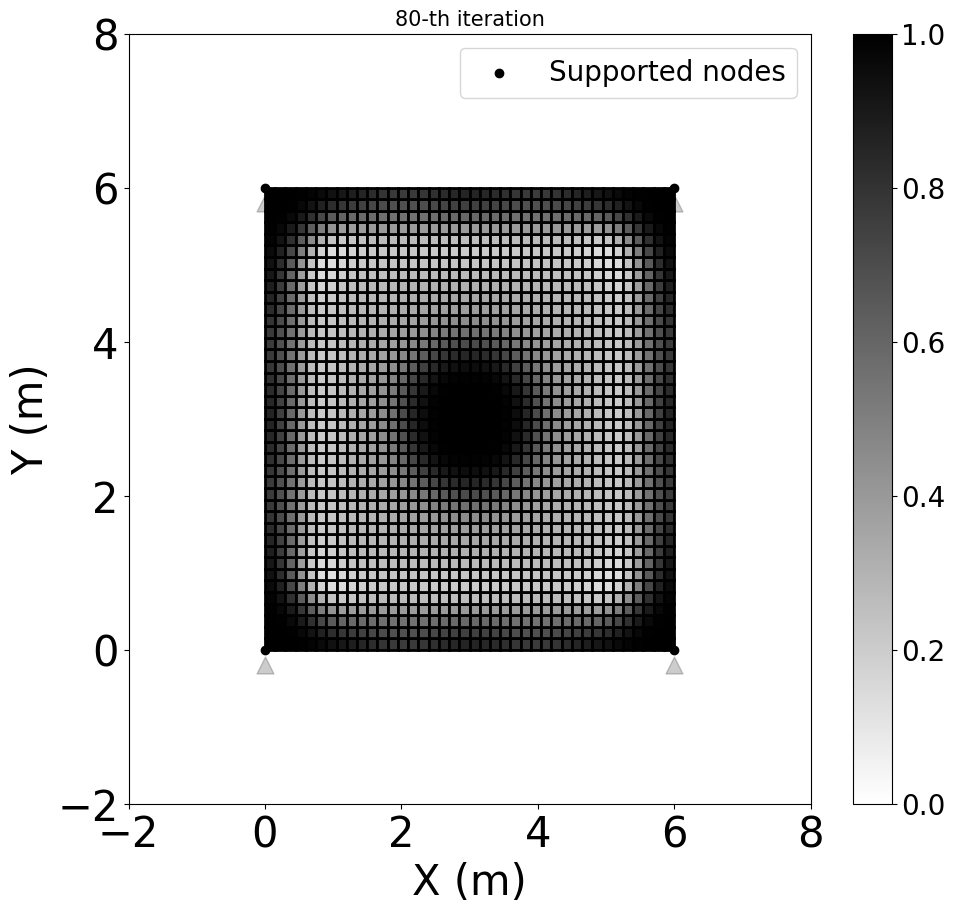

81th iteration, C = 0.22013275378147795 
82th iteration, C = 0.22287528733340156 
83th iteration, C = 0.22568430378832072 
84th iteration, C = 0.22856154387874844 
85th iteration, C = 0.23150878979622255 
798.7191163661947


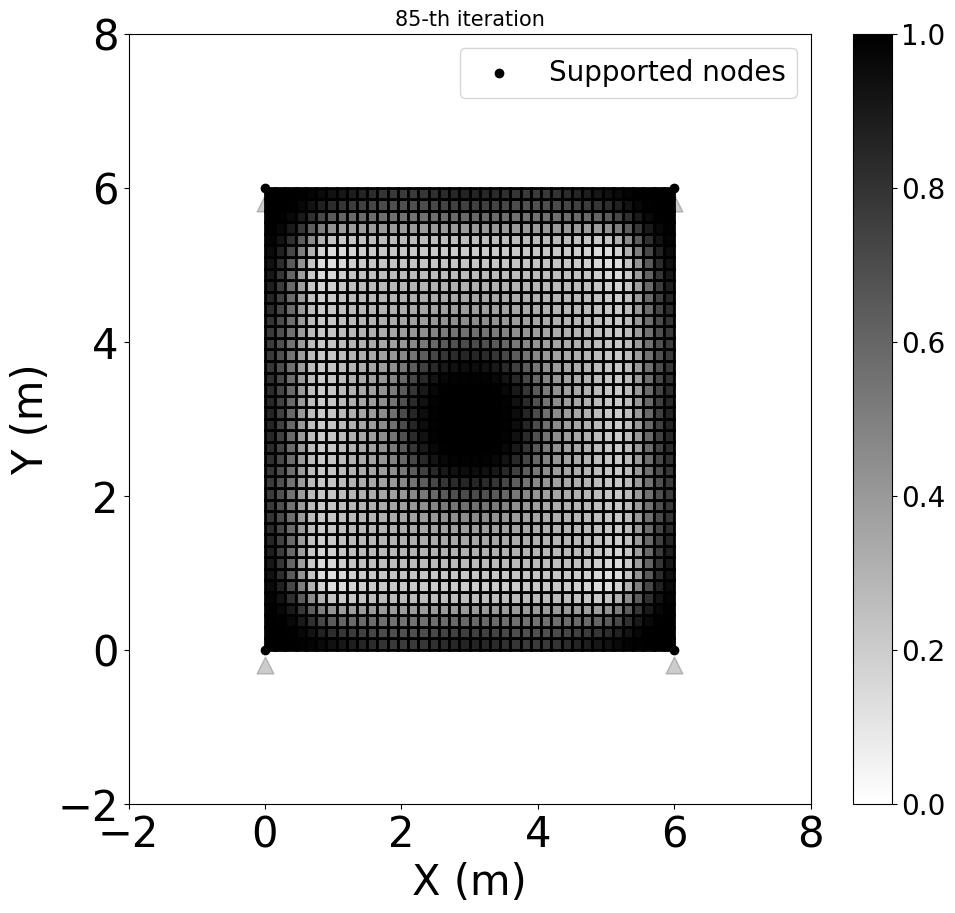

86th iteration, C = 0.23452787332687014 
87th iteration, C = 0.2376206735737212 
88th iteration, C = 0.24078911902185215 
89th iteration, C = 0.2440351887583307 
90th iteration, C = 0.24736091372496236 
798.7191163661947


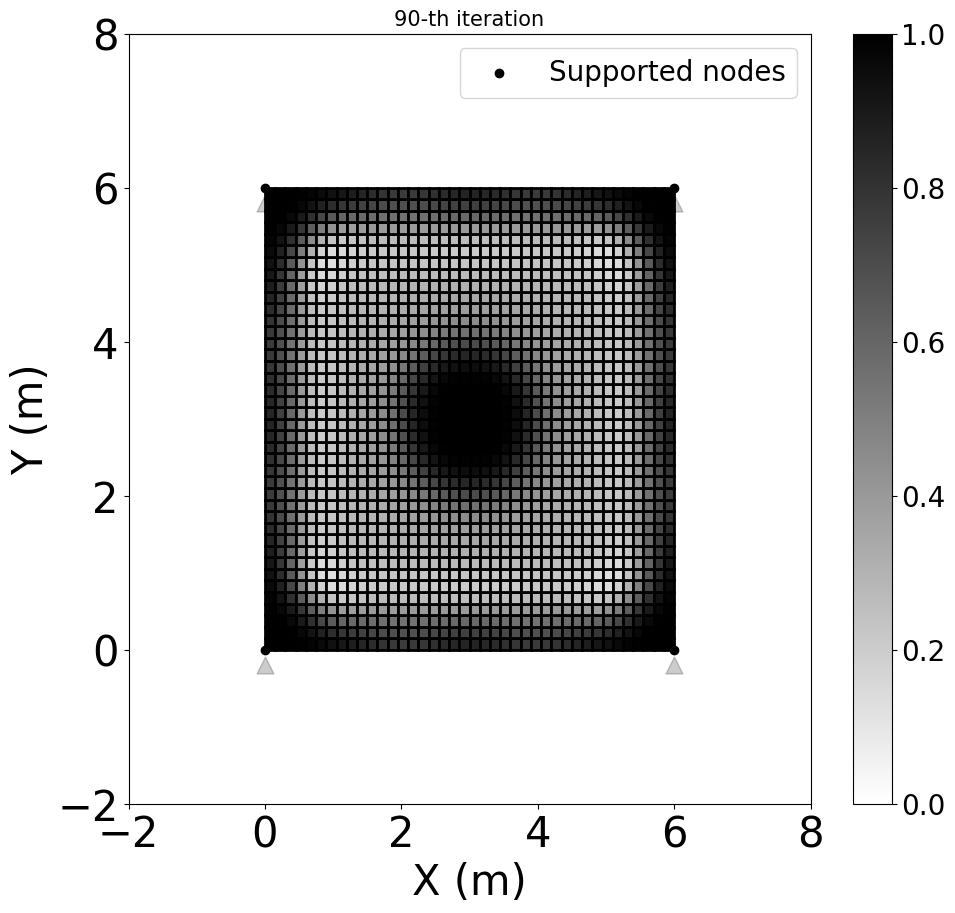

91th iteration, C = 0.25076837810504005 
92th iteration, C = 0.2542597223406663 
93th iteration, C = 0.2578371399536521 
94th iteration, C = 0.261502885123539 
95th iteration, C = 0.2652592707510374 
798.7191163661947


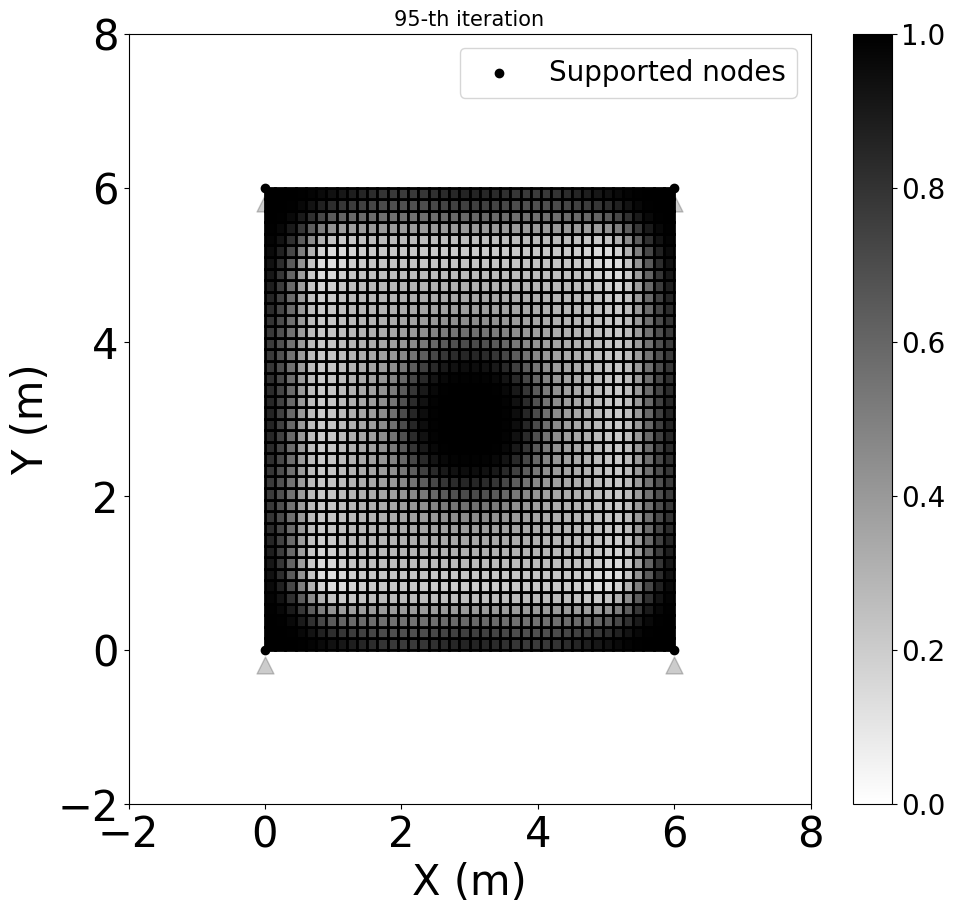

96th iteration, C = 0.26910866908034203 
97th iteration, C = 0.27305351543850276 
98th iteration, C = 0.2770963091028888 
99th iteration, C = 0.2812396157962089 
100th iteration, C = 0.285486066851215 
798.7191163661947


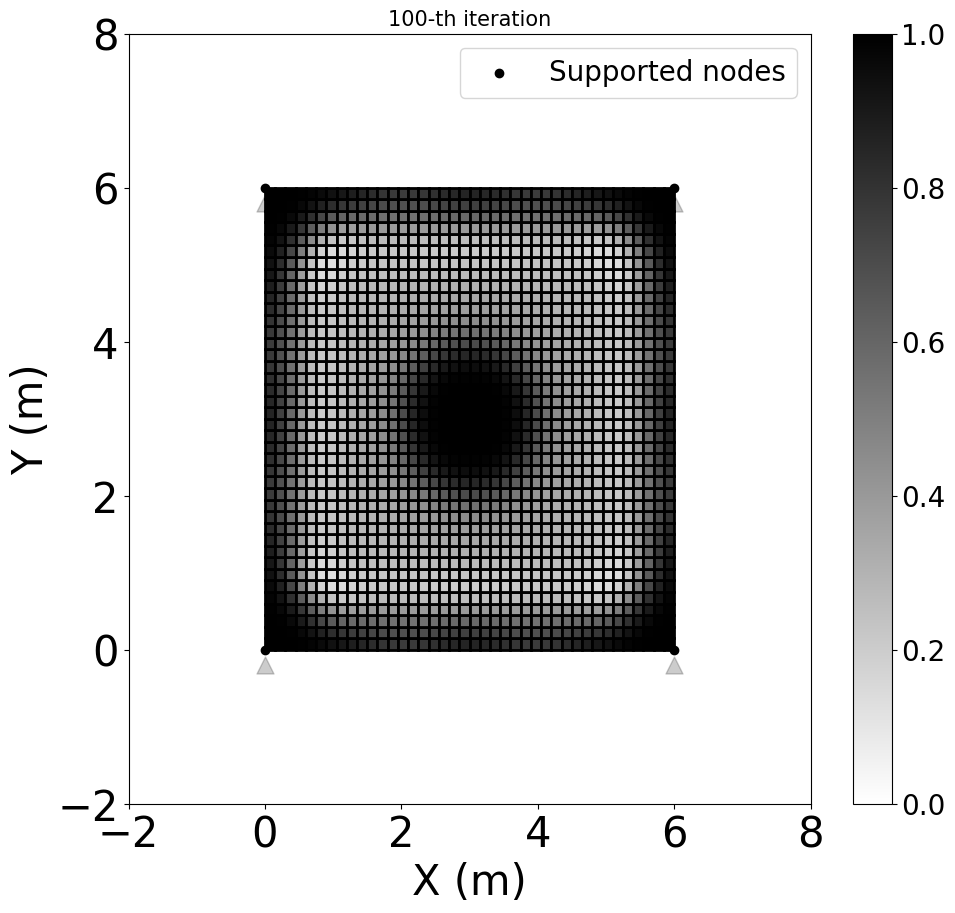

In [81]:

n_dim = sso_model.parameter_values.shape[0]
opt = nlopt.opt(nlopt.LD_MMA, n_dim)
opt.set_min_objective(f)
opt.set_lower_bounds(0.01*np.ones(n_dim)) # Lower bounds
opt.set_upper_bounds(np.ones(n_dim)) #Upper bounds
opt.set_maxeval(100)
opt.add_inequality_constraint(fc)

xopt = opt.optimize(x_ini)


    
    
    

In [82]:
np.array(C_hist)*1000

array([8763.41491351, 2899.51074249, 2735.30580173, 1652.75054567,
        492.04012384,  410.92872401,  189.13449323,  135.3327228 ,
        127.53765715,  125.82204959,  124.93585117,  124.95748823,
        125.82767056,  126.57708882,  127.37700159,  128.1122217 ,
        128.79219044,  129.47771951,  130.17534351,  130.88603258,
        131.61019511,  132.34818877,  133.10037412,  133.86712204,
        134.64881177,  135.44583195,  136.25858226,  137.08747232,
        137.93292265,  138.79536381,  139.67523956,  140.5730029 ,
        141.48911848,  142.42406577,  143.37833483,  144.35242788,
        145.34686152,  146.36216553,  147.39888239,  148.45757057,
        149.53880169,  150.64316262,  151.7712558 ,  152.92369943,
        154.10112676,  155.30418952,  156.5335543 ,  157.78990688,
        159.07395035,  160.38640534,  161.7280128 ,  163.09953243,
        164.50174247,  165.9354432 ,  167.40145583,  168.9006223 ,
        170.43380652,  172.00189625,  173.60580046,  175.24645

Text(0, 0.5, 'Total strain energy (N$\\cdot$m)')

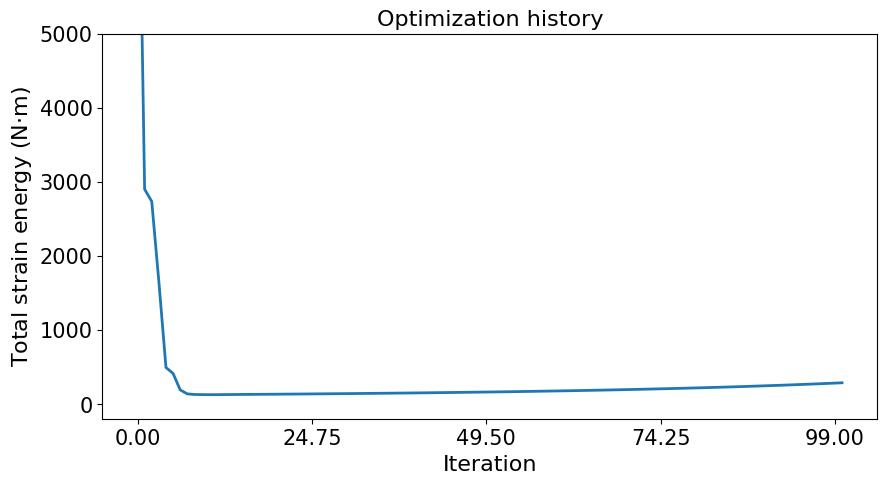

In [83]:

n_iter = np.array(C_hist).shape[0]
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(np.linspace(0,n_iter,n_iter),np.array(C_hist)*1000,linewidth=2)
plt.xticks(np.linspace(0,n_iter-1,5),fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim(-200,5000)
plt.xlabel('Iteration',fontsize=16)
plt.title('Optimization history',fontsize=16)
plt.ylabel(r'Total strain energy (N$\cdot$m)',fontsize=16)

In [84]:
mu_opt = xopt[sso_model.nodeparameters_values.shape[0]:]

In [85]:
objective_filter(xopt)

101th iteration, C = 0.2898383646246125 


(0.2898383646246125,
 Array([-0.00236938, -0.002512  , -0.00215159, ..., -0.00215159,
        -0.002512  , -0.00236938], dtype=float64))

# Visualization

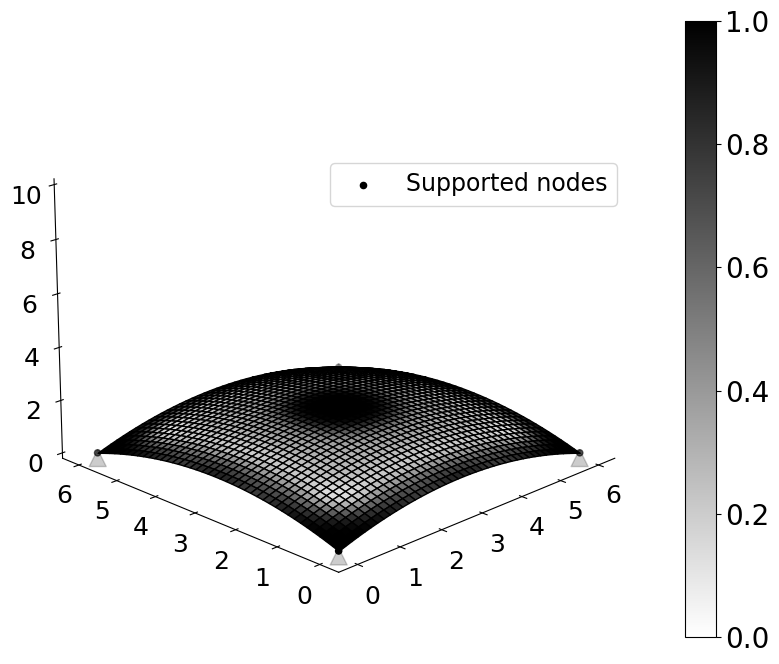

In [86]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -135)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

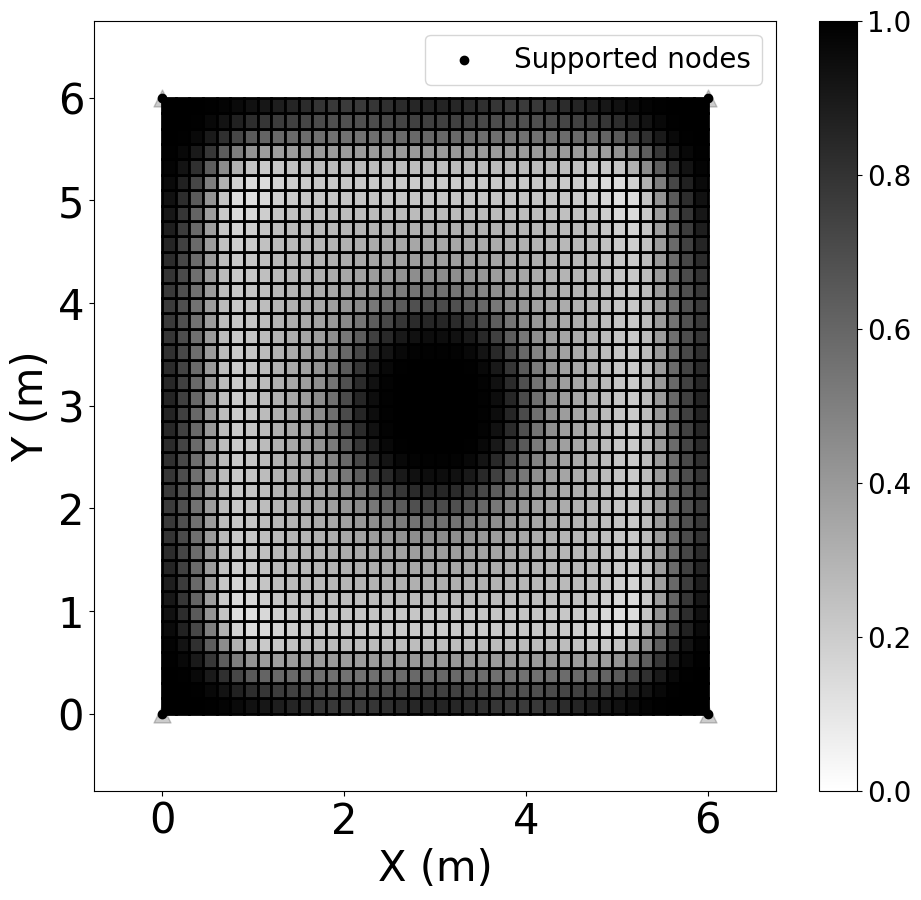

In [87]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

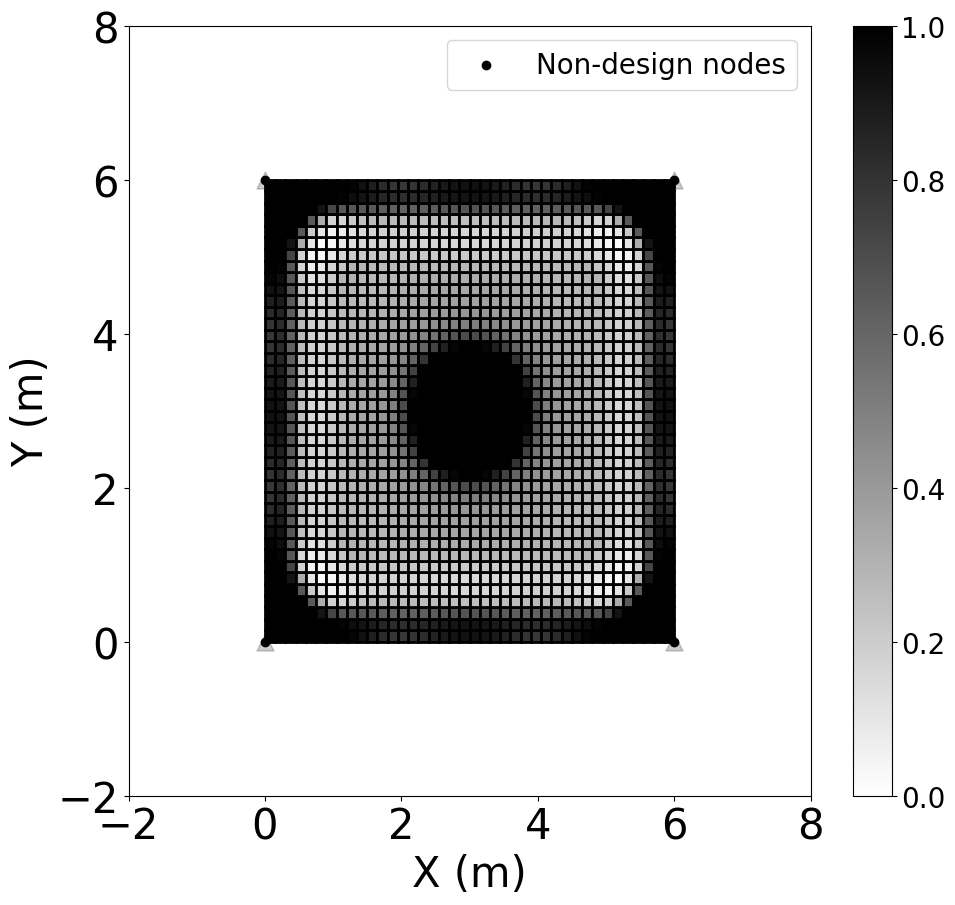

In [88]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()